In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from DataHelper import *

In [26]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [27]:
def compute_MA(df, price_column, n=10):
    return df[price_column].rolling(n).mean()

def pipeline_preprocessing(path, price_column, predict_n=1, thresh_diff=0.5, verbose=False):
    df = get_data(path)
    keep_columns = ['Date', price_column, 'Volume', 'Open']
    df = df.loc[:, keep_columns]
    
    df['Difference'] = compute_column_difference(df, column=price_column, periods_offset=predict_n)
    df['PercentageDiff'] = compute_percentage_diff(df)
    df['Tendency'] = compute_tendency_percentage(df, diff_column='Difference', labels=['lower','higher'])
    
    if verbose:
        value_counts = df.Tendency.value_counts().to_dict()
        for value, count in value_counts.items():
            print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")
            
    df['MA'] = compute_MA(df, price_column)
    df['MA_diff'] = compute_MA(df, price_column, n=20) - compute_MA(df, price_column, n=10)
    df['RSI'] = compute_RSI(df, n=10, price_column=price_column, diff_column='Difference')
    df['GAP'] = compute_GAP(df)
    df['Volume_diff'] = compute_column_difference(df, column='Volume')
    df['Next'] = shift_values(df, column='Tendency', periods=-predict_n)
    df = df.dropna()
    return df

In [28]:
DATA_PATH = './data'
QUOTATIONS = ['AMZN', 'GOOG', 'AAPL', 'GM', 'TSLA', 'JNJ', 'XOM', 'AAL', 'KO', 'WMT']
FILE_SUFFIX = '.txt'
price_column = 'Close'

df = None
predict_n = 5

for quot in QUOTATIONS:
    #temp_df = pipeline_preprocessing(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n, price_column=price_column)
    temp_df, feature_names = features_pipeline(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n,
                                price_column=price_column, normalize_features=True, 
                                base_features_normalize=['Volume'])
    if df is None:
        df = temp_df
    else:
        df = df.append(temp_df)

print(len(df))
df.head()
df = df.dropna()

33154


In [29]:
df.isna().any()

Date              False
Open              False
High              False
Low               False
Close             False
Volume            False
Adjusted          False
Difference        False
PercentageDiff    False
Tendency          False
MA                False
MA_diff           False
RSI               False
GAP               False
Volume_diff       False
Next              False
dtype: bool

In [30]:
from torch.utils.data import Dataset

class StocksDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.Tensor(data.values)
        self.target = torch.Tensor(target.values)
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return datapoint, target
        
    def __len__(self):
        return len(self.data)

y_column = 'Next'
data_columns = ['Close', 'Volume'] + feature_names


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':0})
    

    
X = dataset.loc[:, dataset.columns != y_column]
Y = dataset[y_column]

#print(X.head())

dataset = StocksDataset(X,Y)
print(Y.head())
X.head()

20    1
21    1
22    1
23    1
24    1
Name: Next, dtype: int64


,Close,Volume,Difference,PercentageDiff,Tendency,MA,MA_diff,RSI,GAP,Volume_diff
20,37.669998,0.080954,0.490887,0.267915,1,0.000948,0.546187,0.572571,0.560016,0.345348
21,38.700001,0.066763,0.489585,0.230683,1,0.000878,0.546726,0.454051,0.562088,0.321363
22,37.389999,0.083949,0.488559,0.202095,1,0.000780,0.547625,0.327026,0.562117,0.347003
23,37.160000,0.115680,0.493521,0.341316,0,0.000693,0.548677,0.224176,0.558674,0.358890
24,38.270000,0.075046,0.492786,0.319791,1,0.000607,0.549528,0.125073,0.560250,0.299753


array([[<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'Difference'}>],
       [<AxesSubplot:title={'center':'PercentageDiff'}>,
        <AxesSubplot:title={'center':'Tendency'}>,
        <AxesSubplot:title={'center':'MA'}>],
       [<AxesSubplot:title={'center':'MA_diff'}>,
        <AxesSubplot:title={'center':'RSI'}>,
        <AxesSubplot:title={'center':'GAP'}>],
       [<AxesSubplot:title={'center':'Volume_diff'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

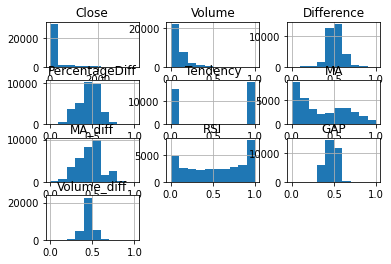

In [31]:
X.hist()

In [32]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [33]:
import torch.nn as nn

class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1),
            #nn.Softmax(1),
        )
        
        
    def forward(self, x):
        out = self.classifier(x)
        #print(out)
        return out
    
import DL_utils
import importlib
importlib.reload(DL_utils)
from DL_utils import train

def create_model(lr, input_dim):
    model = LinearModel(input_dim=input_dim)
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    return model, optimizer, loss_fn

lr = 1e-5

model, optimizer, loss_fn = create_model(lr, input_dim = len(X.columns))
model = model.to(device)
train(dataloader, model, n_epochs=50, optimizer=optimizer, loss_fn=loss_fn, device=device)

Epoch 1, loss: 0.7084876298904419, accuracy : 53.91
Epoch 2, loss: 0.698089063167572, accuracy : 54.24
Epoch 3, loss: 0.7185798287391663, accuracy : 54.21
Epoch 4, loss: 0.6911024451255798, accuracy : 54.27
Epoch 5, loss: 0.6694172620773315, accuracy : 54.18
Epoch 6, loss: 0.6788281798362732, accuracy : 54.28
Epoch 7, loss: 0.7099964022636414, accuracy : 54.28
Epoch 8, loss: 0.6708967685699463, accuracy : 54.25
Epoch 9, loss: 0.6601951718330383, accuracy : 54.17
Epoch 10, loss: 0.6832697987556458, accuracy : 54.26
Epoch 11, loss: 0.7076898217201233, accuracy : 54.29
Epoch 12, loss: 0.6828552484512329, accuracy : 54.22
Epoch 13, loss: 0.7124038338661194, accuracy : 54.23
Epoch 14, loss: 0.7123175859451294, accuracy : 54.10
Epoch 15, loss: 0.671181321144104, accuracy : 54.33


KeyboardInterrupt: 